# Model Development

Normally, one would use CNN for image classification problems, but for this project I am using a different approach. There are other machine learning algorithms that can perform decently in image classification. 

I will be using the ***Scikit-learn*** library for this classification task.

In [1]:
# Import necessary packages.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
import pickle
import json

In [2]:
# Load the training data variables
%store -r X
%store -r Y

In [3]:
X.shape, len(Y)

((541, 4096), 541)

In [4]:
# Split the data into training and testing chunks.
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.1, random_state=123)

Let's use the SVC model and see how well it performs.

In [5]:
C = 100
pipeline = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="linear", C=C))])
# Training step.
pipeline.fit(X_train, Y_train)
accuracy = pipeline.score(X_test, Y_test)
print(f"Accuracy of the classifier: {accuracy*100:.2f}%")

Accuracy of the classifier: 90.91%


We can view a more detailed performance and measure the quality of the model using the classification report. The metrics of the report is compiled using **True Positive**, **True Negative**, **False Positive**, **False Negative**. These are generally used to assess a classification algorithm.  
**TN / True Negative**: when a case was negative and predicted negative.  
**TP / True Positive**: when a case was positive and predicted positive.  
**FN / False Negative**: when a case was positive but predicted negative.  
**FP / False Positive**: when a case was negative but predicted positive.  

In [6]:
print(cr(Y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       1.00      1.00      1.00         8
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00        12
           4       0.90      0.90      0.90        10
           5       0.75      0.86      0.80         7

    accuracy                           0.91        55
   macro avg       0.89      0.88      0.88        55
weighted avg       0.91      0.91      0.91        55



**Precision** measures the accuracy of positive prediction: ```TP/(TP+FP)```  
**Recall** measures the ability of the model to correctly predict positive cases: ```TP/(TP+FN)```  
**F1-score** is a harmonic mean of precision and recall: ```2 * (Precision*Recall)/(Precision+Recall)```

The tedious job in model training is hyperparameter tuning. In most case, your first choice of hyperparameters might not be the best to fully optimise the model; as a result, there's a need to fine-tune these hyperparameters to make the best of the model.

It is always better to implement an automated approach towards solving a time-consuming task, instead of handling it manually; hence, I'll use **GridSearchCV** to tune hyperparameters and finally select the hyperparamters that best optimise the model.

In [7]:
# Create a nested dictionary that holds the different classification algorithm and the parameters used to tune each of them.
models_and_params = {
    "svm": {
        "model": SVC(gamma="auto", probability=True),
        "params": {
            "svc__C": [1, 10, 100, 1000],
            "svc__kernel": ["rbf", "linear"]
        }
    },
    
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear", multi_class="auto"),
        "params": {
            "logisticregression__C": [1, 5, 10]
        }
    },
    
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "randomforestclassifier__n_estimators": [1, 5, 10]
        }
    }
}

In [8]:
# Run a loop that uses GridSearchCV to tune the parameters.
cv=10
scores = []
best_estimators = {}
for algorithm, mp in models_and_params.items():
    pipeline = make_pipeline(StandardScaler(), mp["model"])
    # Training with Cross-validation.
    classifier = GridSearchCV(pipeline, mp["params"], cv=cv, return_train_score=False)  
    classifier.fit(X_train, Y_train)
    scores.append({
        "model": algorithm,
        "best_score": classifier.best_score_,
        "best_params": classifier.best_params_
    })
    
    # Save the best optimised model.
    best_estimators[algorithm] = classifier.best_estimator_

# View scores in a table to get more insight.
df = pd.DataFrame(scores)
df

,model,best_score,best_params
0,svm,0.837798,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,logistic_regression,0.870706,{'logisticregression__C': 1}
2,random_forest,0.599192,{'randomforestclassifier__n_estimators': 10}


In [9]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))])}

**best_estimators** holds the optimised models which we can evaluate using the test chunk of the dataset.

Let's see how these optimised models perform....

In [10]:
svm_accuracy = best_estimators["svm"].score(X_test, Y_test)
print(f"Accuracy of SVC model on the test set: {accuracy*100:.2f}%")

Accuracy of SVC model on the test set: 90.91%


In [11]:
lr_accuracy = best_estimators["logistic_regression"].score(X_test, Y_test)
print(f"Accuracy of Logistic Regression model on the test set: {lr_accuracy*100:.2f}%")

Accuracy of Logistic Regression model on the test set: 90.91%


In [12]:
rfc_accuracy = best_estimators["random_forest"].score(X_test, Y_test)
print(f"Accuracy of Logistic Regression model on the test set: {rfc_accuracy*100:.2f}%")

Accuracy of Logistic Regression model on the test set: 87.27%


The SVC model proves to be the best model for this classification task, with over 90% accuracy; hence, it will be used for production.  

However, there are cases where the model made errors because, it's not 100% perfect. We can see where the model made such errors and classified wrongly using a ***confusion matrix***.  

In [13]:
cm = confusion_matrix(Y_test, best_estimators["svm"].predict(X_test))
cm

array([[12,  0,  0,  0,  1,  0],
       [ 0,  8,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  2],
       [ 0,  0,  0, 12,  0,  0],
       [ 1,  0,  0,  0,  9,  0],
       [ 0,  0,  1,  0,  0,  6]], dtype=int64)

This confusion matrix helps to assess the performance of the model in classifying each case correctly.  
It is easier to understand the confusion matrix when plotted on a heatmap.

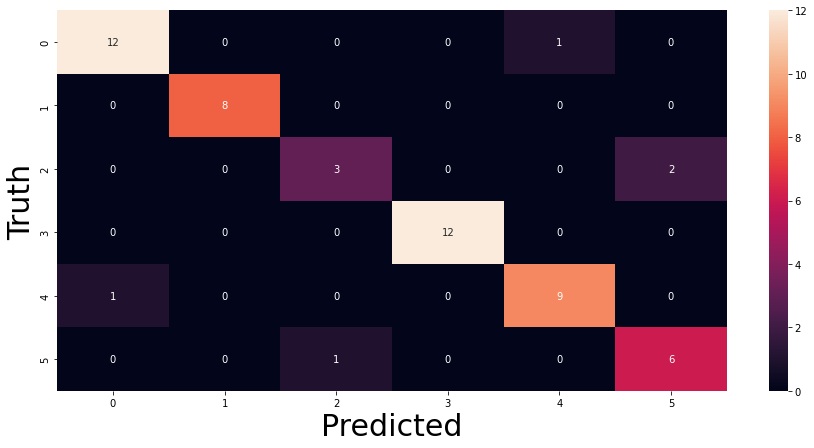

In [14]:
# Plot the confusion matrix on a heatmap.
plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted", fontsize=30)
plt.ylabel("Truth", fontsize=30)
plt.show()

There are six classes (0-5);  
{'cristiano_ronaldo': 0,
 'karim_benzema': 1,
 'leo_messi': 2,
 'mohamed_salah': 3,
 'robert_lewandoski': 4,
 'zlatan_ibrahimovic': 5}  
 
X-axis: model's prediction, Y-axis: actual class.  
The heatmap plots the model's prediction against the actual class.  
The model was able to classify all of Leo Messi's images correctly(x:2, y:2).  
Also, the model misclassified one of Cristiano Ronaldo's image as Karim Benzema(x:0, y:1), and correctly classified other images(x:0, y:0) 

We can now save the model and use it for production. I'll also save the label_dict variable.

In [15]:
optimised_classifier = best_estimators["svm"]
# Save the model as a serialised object in a pickle file.
with open("model.pickle", "wb") as f:
    pickle.dump(optimised_classifier, f)

In [18]:
%store -r label_dict
# Save the label_dict variable as a json file.
with open("label_dict.json", "w") as f:
    f.write(json.dumps(label_dict))

In [19]:
# ifunanyaScript